In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns

In [3]:
#General visualization settings
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)

In [4]:
#Path settings

root_path = Path(r"D:\CricketVR\RoundtripBenchmarking")
session_id = "05_31_2022_11_21_08"

session_path = root_path / session_id

### Roundtrip benchmarking for SWC Harp implementation

- Trigger On-Off pulse (timestamp off event)
- Read falling-edge event (timestamp digital off event)
- Back to top
- Since we are only triggering on falling edges the difference we are looking for for the roundtrip is between the digitalWrite(LOW) of time (t) and digitalWrite(HIGH) of time (t+1)
- There might be a frame shift on the first sample between writes and reads...It could also be the dump of the digital input?

In [5]:
# Load data
## Compare SWC-HARP and CF-HARP timestamping
ArmCommandsEvent = pd.read_csv(session_path / "ArmCommandsWriteEvent.csv") # Software event
ArmCommandBonsai = pd.read_csv(session_path / "ArmCommandsBonsai.csv") # Write feedback event

FallingEdgeEvent = pd.read_csv(session_path / "FallingEdgeEvents.csv") # I/o falling edge read event

ArmCommandsEvent



,Payload,Seconds,LatestHarpTimestamp
0,1,500569.450784,500569.455008
1,0,500569.472000,500569.476064
2,1,500569.482528,500569.484032
3,0,500569.502400,500569.506016
4,1,500569.512896,500569.515008
...,...,...,...
986,1,500584.300992,500584.303008
987,0,500584.320832,500584.325024
988,1,500584.331424,500584.333024
989,0,500584.349952,500584.354016


Text(0, 0.5, 'Counts')

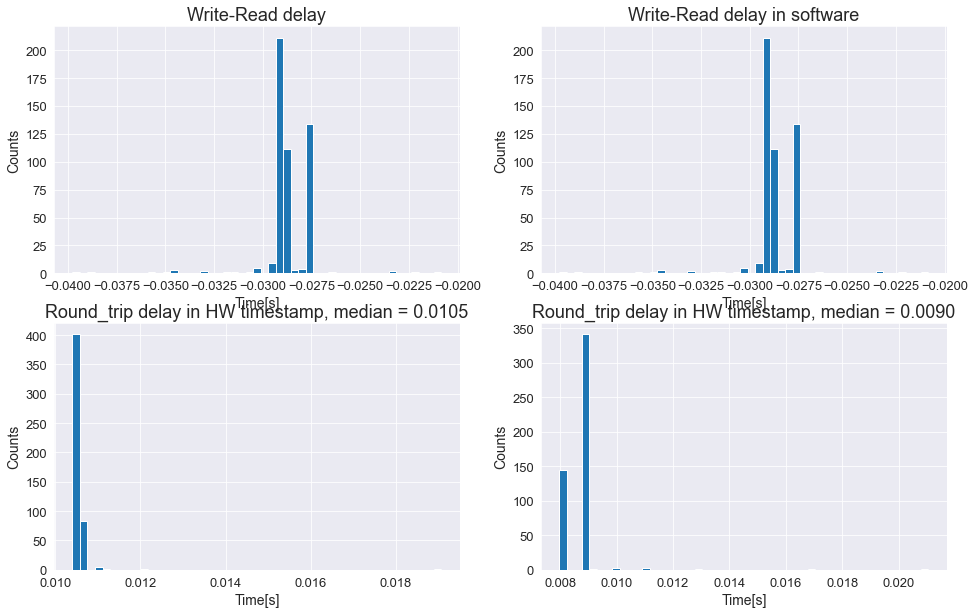

In [6]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches((16, 10))

## Diffs between writes and reads in HW
write_falling_edge = ArmCommandsEvent.loc[ArmCommandsEvent["Payload"] == 0, "Seconds" ].values
read_falling_edge = FallingEdgeEvent.loc[:, "Seconds"].values
delta_ts = write_falling_edge[:-1] - read_falling_edge[1:] # I think there is a phase shift in the first sample????

bins = np.linspace(np.min(delta_ts), np.max(delta_ts), 50)
ax[0,0].hist(delta_ts, bins)
ax[0,0].set_title("Write-Read delay")
ax[0,0].set_xlabel("Time[s]")
ax[0,0].set_ylabel("Counts")


## Diffs between writes and reads in SW (Bonsai using the latest timestamp from the harp photodiode event)
write_falling_edge_sw = ArmCommandsEvent.loc[ArmCommandsEvent["Payload"] == 0, "LatestHarpTimestamp"].values
read_falling_edge_sw = FallingEdgeEvent.loc[:, "LatestHarpTimestamp"].values
delta_ts_sw = write_falling_edge[:-1] - read_falling_edge[1:]

bins = np.linspace(np.min(delta_ts_sw), np.max(delta_ts_sw), 50)
ax[0,1].hist(delta_ts_sw, bins)
ax[0,1].set_title("Write-Read delay in software")
ax[0,1].set_xlabel("Time[s]")
ax[0,1].set_ylabel("Counts")

#very low jitter whether timestamping from HW or Bonsai...


## Roundtrip in HW
ArmCommandsEvent_crop = ArmCommandsEvent.copy()
first_sample_idx = np.where(ArmCommandsEvent_crop["Payload"].values == 0)[0][0]
ArmCommandsEvent_crop = ArmCommandsEvent_crop.loc[first_sample_idx:,:]

write_HIGH = ArmCommandsEvent_crop.loc[ArmCommandsEvent["Payload"] == 1, "Seconds"].values
write_LOW = ArmCommandsEvent_crop.loc[ArmCommandsEvent["Payload"] == 0, "Seconds"].values

delta_ts_roundtrip = write_HIGH - write_LOW[0:write_HIGH.shape[0]] #Low happens first
bins = np.linspace(np.min(delta_ts_roundtrip), np.max(delta_ts_roundtrip), 50)
ax[1,0].hist(delta_ts_roundtrip, bins)
ax[1,0].set_title("Round_trip delay in HW timestamp, median = {mm:.4f}".format(mm = np.median(delta_ts_roundtrip)))
ax[1,0].set_xlabel("Time[s]")
ax[1,0].set_ylabel("Counts")


## Roundtrip in SW

write_HIGH = ArmCommandsEvent_crop.loc[ArmCommandsEvent["Payload"] == 1, "LatestHarpTimestamp"].values
write_LOW = ArmCommandsEvent_crop.loc[ArmCommandsEvent["Payload"] == 0, "LatestHarpTimestamp"].values

delta_ts_roundtrip_sw = write_HIGH - write_LOW[0:write_HIGH.shape[0]] #Low happens first
bins = np.linspace(np.min(delta_ts_roundtrip_sw), np.max(delta_ts_roundtrip_sw), 50)
ax[1,1].hist(delta_ts_roundtrip_sw, bins)
ax[1,1].set_title("Round_trip delay in HW timestamp, median = {mm:.4f}".format(mm = np.median(delta_ts_roundtrip_sw)))
ax[1,1].set_xlabel("Time[s]")
ax[1,1].set_ylabel("Counts")



mean±std = 10.5855±0.5446 [ms] 


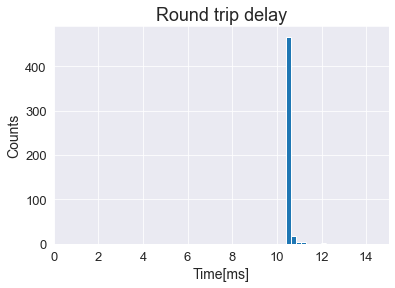

In [23]:

## Roundtrip in HW
ArmCommandsEvent_crop = ArmCommandsEvent.copy()
first_sample_idx = np.where(ArmCommandsEvent_crop["Payload"].values == 0)[0][0]
ArmCommandsEvent_crop = ArmCommandsEvent_crop.loc[first_sample_idx:,:]

write_HIGH = ArmCommandsEvent_crop.loc[ArmCommandsEvent["Payload"] == 1, "Seconds"].values
write_LOW = ArmCommandsEvent_crop.loc[ArmCommandsEvent["Payload"] == 0, "Seconds"].values

delta_ts_roundtrip = write_HIGH - write_LOW[0:write_HIGH.shape[0]] #Low happens first
delta_ts_roundtrip *= 1000
bins = np.linspace(np.min(delta_ts_roundtrip), np.max(delta_ts_roundtrip), 40)
#print(delta_ts_roundtrip)
print("mean±std = {mm:.4f}±{ss:.4f} [ms] ".format(mm = np.mean(delta_ts_roundtrip), ss = np.std(delta_ts_roundtrip)))
fig = plt.figure()
plt.hist(delta_ts_roundtrip, bins)
plt.title("Round trip delay")
plt.xlabel("Time[ms]")
plt.ylabel("Counts")
plt.xlim((0,0.015e3))
plt.show()
